In [1]:

from sys import path as syspath
from os import path as ospath
from astropy import units as u

syspath.append('../')
syspath.append('../_mining')

In [2]:
from discminer.disc2d import Model

SyntaxError: invalid syntax (disc2d.py, line 804)

# Prepare datacube

In [3]:
#this is for preparing the data
from discminer.core import Data
import astropy.units as u

file_data = '../template/MWC_480_CO_220GHz.robust_0.5.JvMcorr.image.pbcor'
dpc = 162.0*u.pc

#**********************
#DATACUBE FOR PROTOTYPE
#**********************
datacube = Data(file_data+'.fits', dpc)

datacube.clip(npix=250,  overwrite=True) # can also clip along the velocity axis using e.g. channels={"interval": [15, 115]})
datacube.downsample(2, tag='_2pix') # Downsample cube and add tag to filename

#**********************
#DATACUBE FOR MCMC FIT
#**********************
datacube = Data(file_data+'_clipped.fits', dpc)
datacube.downsample(10, tag='_10pix')


KeyboardInterrupt: 

# Pipeline

* fit the geometrical properties in a standard way (see example/fit/fit_mc_mwc480.py)
* the fit generates a log file
* run `discminer parfile` that generates a parfile based on the mcmc fit log

# The following code should open the parfile and load the fitted model

In [3]:
#loading the datacube under exam
from discminer.core import Data
from discminer import units as ucf
file_data = '../template/MWC_480_CO_220GHz.robust_0.5.JvMcorr.image.pbcor_clipped_downsamp_10pix.fits'
dpc = 162.0*u.pc
datacube = Data(file_data, dpc)

In [4]:
import json
with open('parfile.json') as json_file:
    pars = json.load(json_file)

meta = pars['metadata']
best = pars['best_fit']
custom = pars['custom']

chan_step = custom['chan_step']
nchans = custom['nchans']

#****************
#SOME DEFINITIONS
#****************ln_like
file_data = meta['file_data']
tag = meta['tag']
au_to_m = u.au.to('m')

dpc = meta['dpc']*u.pc



In [5]:
from utils import get_noise_mask, init_data_and_model
import numpy as np
#*******************
#LOAD DATA AND MODEL
#*******************
datacube, model = init_data_and_model(Rmin=0, Rmax=1.2)
vchannels = datacube.vchannels
pix_downsamp = model.grid['step']*meta['downsamp_fit']/au_to_m

#Useful definitions for plots
xmax = model.skygrid['xmax'] 
xlim = 1.0*xmax/au_to_m
extent= np.array([-xmax, xmax, -xmax, xmax])/au_to_m
  


     _  _                        _                    
  __| |(_) ___   ___  _ __ ___  (_) _ __    ___  _ __ 
 / _` || |/ __| / __|| '_ ` _ \ | || '_ \  / _ \| '__|
| (_| || |\__ \| (__ | | | | | || || | | ||  __/| |   
 \__,_||_||___/ \___||_| |_| |_||_||_| |_| \___||_|   
                                                      

*====================================================================================================*
Computing grid...
Grid maximum extent: 120689578165943.16
Grid step (cell size): 969394202136.0896
*====================================================================================================*
*====================================================================================================*
Computing grid...
Grid maximum extent: 128444731783031.88
Grid step (cell size): 969394202136.0896
*====================================================================================================*
Setting beam_info var to Beam: BMAJ=0.165413767099392 arcse

# Run standard model

In [6]:
%%timeit
#**************************
#MAKE MODEL (2D ATTRIBUTES)
#**************************
#Return model cube and computes disc coordinates projected on the sky
if meta['mol'] in ['12co', '13co'] and pix_downsamp>1.01*model.beam_size.value:
    modelcube = model.make_model(make_convolve=False) 
else:
    modelcube = model.make_model(make_convolve=True) 

modelcube.filename = 'cube_model_%s.fits'%tag

modelcube.convert_to_tb(writefits=False)

*====================================================================================================*
Running prototype model with the following parameters:

{'height_lower': {'Rb': 803.90594,
                  'p': 1.107099,
                  'q': 2.859784,
                  'z0': 14.227028},
 'height_upper': {'Rb': 108.607483,
                  'p': 1.65208,
                  'q': 0.550336,
                  'z0': 52.680114},
 'intensity': {'I0': 0.10439999999999999,
               'Rout': 717.971915,
               'p': -2.659016,
               'q': 2.156254},
 'lineslope': {'Ls': 1.676401, 'p': 0.314061},
 'linewidth': {'L0': 0.316459, 'p': -0.288951, 'q': -0.355926},
 'orientation': {'PA': 1.010296,
                 'incl': -0.672928,
                 'xc': -0.91338,
                 'yc': -1.826827},
 'velocity': {'Mstar': 1.973085, 'vel_sign': -1.0, 'vsys': 5.099463}}

*====================================================================================================*
*=====

# find a way to change the v field of the model

In [18]:
from discminer import emulator
emu = emulator.Emulator()
model.velocity_func = emu.emulate_v3d

Setting velocity function to <bound method Emulator.emulate_v3d of <discminer.emulator.Emulator object at 0x7f16ee924c70>>


In [40]:
emu_params = {
    'alpha': 1e-3,
    'h': 0.05,
    'planetMass': 1e-2,
    'sigmaSlope': 1,
    'flaringIndex': 0.25,
    'R_p': 150*ucf.au,
    'phi_p':np.pi/4,
    'extrap_vfunc': model.keplerian
}

In [41]:
model.params['velocity'].update(emu_params)

In [42]:
model.params['orientation']['incl'] = -45 

In [43]:
#model.params['velocity']['phi_p'] = 45

In [44]:
model.params

{'velocity': {'Mstar': 1.973085,
  'vsys': 5.099463,
  'vel_sign': -1.0,
  'alpha': 0.001,
  'h': 0.05,
  'planetMass': 0.01,
  'sigmaSlope': 1,
  'flaringIndex': 0.25,
  'R_p': 22439680605000.0,
  'phi_p': 0.7853981633974483,
  'extrap_vfunc': <function discminer.disc2d.Velocity.keplerian(coord, Mstar=1.0, vel_sign=1, vsys=0)>},
 'orientation': {'incl': -45, 'PA': 1.010296, 'xc': -0.91338, 'yc': -1.826827},
 'intensity': {'I0': 0.10439999999999999,
  'p': -2.659016,
  'q': 2.156254,
  'Rout': 717.971915},
 'linewidth': {'L0': 0.316459, 'p': -0.288951, 'q': -0.355926},
 'lineslope': {'Ls': 1.676401, 'p': 0.314061},
 'height_upper': {'z0': 52.680114,
  'p': 1.65208,
  'Rb': 108.607483,
  'q': 0.550336},
 'height_lower': {'z0': 14.227028,
  'p': 1.107099,
  'Rb': 803.90594,
  'q': 2.859784},
 'phi_p': 45}

In [45]:
#%%timeit
#**************************
#MAKE MODEL (2D ATTRIBUTES)
#**************************
#Return model cube and computes disc coordinates projected on the sky
if meta['mol'] in ['12co', '13co'] and pix_downsamp>1.01*model.beam_size.value:
    modelcube = model.make_model(make_convolve=False) 
else:
    modelcube = model.make_model(make_convolve=True) 

modelcube.filename = 'cube_model_%s.fits'%tag

modelcube.convert_to_tb(writefits=True)

*====================================================================================================*
Running prototype model with the following parameters:

{'height_lower': {'Rb': 803.90594,
                  'p': 1.107099,
                  'q': 2.859784,
                  'z0': 14.227028},
 'height_upper': {'Rb': 108.607483,
                  'p': 1.65208,
                  'q': 0.550336,
                  'z0': 52.680114},
 'intensity': {'I0': 0.10439999999999999,
               'Rout': 717.971915,
               'p': -2.659016,
               'q': 2.156254},
 'lineslope': {'Ls': 1.676401, 'p': 0.314061},
 'linewidth': {'L0': 0.316459, 'p': -0.288951, 'q': -0.355926},
 'orientation': {'PA': 1.010296, 'incl': -45, 'xc': -0.91338, 'yc': -1.826827},
 'phi_p': 45,
 'velocity': {'Mstar': 1.973085,
              'R_p': 22439680605000.0,
              'alpha': 0.001,
              'extrap_vfunc': <function Velocity.keplerian at 0x7f177cd3bd90>,
              'flaringIndex': 0.25,
      

(-1.0, 1.0, -1.0, 1.0)

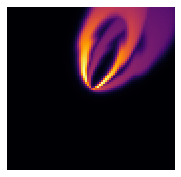

In [72]:
import matplotlib.pyplot as plt
nx = np.linspace(-3,3,250)
plt.pcolormesh(nx,nx,modelcube.data[56], cmap='inferno')
plt.xlim(-1.5,1.5)
plt.ylim(-1,1)
plt.gcf().set_size_inches(3,3)
plt.axis('off')

In [53]:

modelcube.data.shape

(133, 250, 250)

In [13]:
from autograd import grad
import autograd.numpy as npa

def sum(data):
    return npa.mean(data)

In [ ]:
trg = grad(sum)

In [ ]:
trg(modelcube.data)

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(modelcube.data[58])
plt.colorbar()
plt.show()

In [ ]:
model.velocity_func = model.keplerian_vertical_selfgravity_pressure

In [ ]:
modelcube2 = model.make_model()
modelcube2.convert_to_tb()

In [ ]:
res = modelcube2.data-modelcube.data

# Testing emulator

array([ 3.        ,  2.95275591,  2.90551181,  2.85826772,  2.81102362,
        2.76377953,  2.71653543,  2.66929134,  2.62204724,  2.57480315,
        2.52755906,  2.48031496,  2.43307087,  2.38582677,  2.33858268,
        2.29133858,  2.24409449,  2.19685039,  2.1496063 ,  2.1023622 ,
        2.05511811,  2.00787402,  1.96062992,  1.91338583,  1.86614173,
        1.81889764,  1.77165354,  1.72440945,  1.67716535,  1.62992126,
        1.58267717,  1.53543307,  1.48818898,  1.44094488,  1.39370079,
        1.34645669,  1.2992126 ,  1.2519685 ,  1.20472441,  1.15748031,
        1.11023622,  1.06299213,  1.01574803,  0.96850394,  0.92125984,
        0.87401575,  0.82677165,  0.77952756,  0.73228346,  0.68503937,
        0.63779528,  0.59055118,  0.54330709,  0.49606299,  0.4488189 ,
        0.4015748 ,  0.35433071,  0.30708661,  0.25984252,  0.21259843,
        0.16535433,  0.11811024,  0.07086614,  0.02362205, -0.02362205,
       -0.07086614, -0.11811024, -0.16535433, -0.21259843, -0.25

In [ ]:
import sys
sys.path.append('../discminer/')
import emulator
import units as u
import units as sfu
import numpy as np

def hypot_func(x,y):
    return np.sqrt(x**2+y**2)

G = 6.67384e-11 

@staticmethod
def keplerian(coord, Mstar=1.0, vel_sign=1, vsys=0):
    Mstar *= sfu.MSun
    if 'R' not in coord.keys(): R = hypot_func(coord['x'], coord['y'])
    else: R = coord['R'] 
    return vel_sign*np.sqrt(G*Mstar/R) * 1e-3

In [ ]:
emu = emulator.Emulator()

In [ ]:
params = {
    'alpha': 1e-3,
    'h': 0.05,
    'planetMass': 1e-3,
    'sigmaSlope': 1,
    'flaringIndex': 0.25,
    'R_p': 50*u.au,
    'phi_p':0,
    'extrap_vfunc': keplerian
}

x = y = np.linspace(-100,100,500)*u.au
XX, YY = np.meshgrid(x, y)
coord = {
    'x': XX,
    'y': YY
}

In [ ]:
emulation = emu.emulate_v3d(coord, **params)

In [ ]:
emulation.shape

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
plt.imshow(emulation[:,:,2])

In [14]:
es = np.expand_dims(np.ones((10,10)), axis=0).shape

In [15]:
es

(1, 10, 10)